In [1101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from numpy import genfromtxt
import time
import math
import random

In [753]:
def pathLength(pathList):
    totalDistance = 0
    firstPoint_x = pathList[0,0]
    firstPoint_y = pathList[0,1]
    previousCity_x = firstPoint_x
    previousCity_y = firstPoint_y
    
    for partialDist in pathList:  
        currentCity_x = partialDist[0]
        currentCity_y = partialDist[1]
        totalDistance = totalDistance + math.sqrt((previousCity_x-currentCity_x)**2 + (previousCity_y-currentCity_y)**2) 
        previousCity_x = currentCity_x
        previousCity_y = currentCity_y            
                    
    totalDistance = totalDistance + math.sqrt((firstPoint_x-currentCity_x)**2 + (firstPoint_y-currentCity_y)**2) #np.linalg.norm(previousCity-firstPoint) #loops back around to the first point
    return totalDistance

In [1164]:
cities_15 = genfromtxt('15cities.csv', delimiter=',')
cities_25 = genfromtxt('25cities.csv', delimiter=',')
cities_25A = genfromtxt('25cities_A.csv', delimiter=',')
cities_100 = genfromtxt('100cities.csv', delimiter=',')
testCities = genfromtxt('testcities.csv', delimiter=',')
testCities3 = genfromtxt('testcities3x3.csv', delimiter=',')

np.random.seed() #seed the random generator

#for i in range(10):
#simulatedAnnealing(cities_25A,100)
#randomPopulation(cities_15,3)

In [1183]:
def randomSwap(pathList):
    randomPathIndex = np.random.choice(pathList.shape[0],2, replace=False)#picks 2 indicies at random, does not allow the same index to be called twice
    pathList[randomPathIndex[0],:], pathList[randomPathIndex[1],:] = pathList[randomPathIndex[1],:], pathList[randomPathIndex[0],:].copy()
    return pathList

In [802]:
def simulatedAnnealing(citiesList, temperature):
    count = 2 #use this to update T
    solutionsGenerated = 1 #number of soultions generated, updates each time a new path is chosen
    startTime = time.time() #used to keep track opf run time
    T = temperature #temperature variable, may change over time
    bestPath = citiesList[1:,:] #just removes the first row since that is not a city
    np.random.shuffle(bestPath) # creates a random order of cities
    bestPathLength = pathLength(bestPath) #saves the current best path length, initial this is the first random path
    while T > 1:
 
        pathTrial = randomSwap(bestPath) #conducts the city swap on the current best path
        newPathLength = pathLength(pathTrial) #calcutates the new path length of the random swap
        if newPathLength < bestPathLength:
            print(newPathLength)
            print(bestPathLength)
            bestPath = pathTrial
            bestPathLength = newPathLength
            solutionsGenerated += 1
            T *= 0.99
            tspPlot(bestPath)
        elif newPathLength > bestPathLength:
            pickingProb = np.exp(-(newPathLength-bestPathLength)/ T)
            if pickingProb >= np.random.uniform(0.0,1.0):
                bestPath = pathTrial
                bestPathLength = newPathLength
                solutionsGenerated += 1
                T *= 0.99
                print("worst")
                tspPlot(bestPath)
    
        count +=1

        if count > 2000000:
            break
                
    totalTime = time.time() - startTime
    print(bestPathLength, totalTime, solutionsGenerated, count)

In [790]:
def tspPlot(bestPath):
    
    x = bestPath[:,0]
    y = bestPath[:,1]
    
    plt.plot(x,y, 'co')
    
    a_scale = float(max(x))/float(50)
    
    plt.arrow(x[-1],y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale, color ='r', length_includes_head = True)
    
    for i in range(0,len(x)-1):
        plt.arrow(x[i],y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale, color ='g', length_includes_head = True)
    
    plt.xlim(-1,max(x)*1.1)
    plt.ylim(-1,max(y)*1.1)  
    plt.show()


0.31743344139151286
0.33827734686426125
0.3442892117442258
0


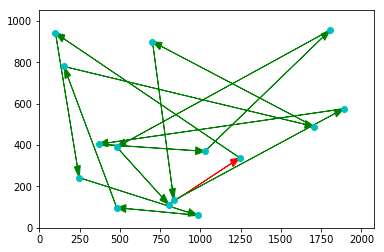

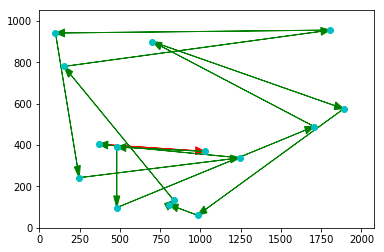

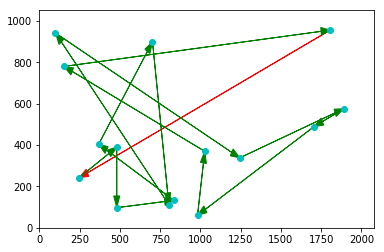

In [1362]:
def evolutionAlgo(citiesList,numPop):  
    
    startTime = time.time() #used to keep track opf run time
    
    bestPath = citiesList[1:,:] #just removes the first row since that is not a city
    #for paths in bestPath:        
    np.random.shuffle(bestPath) # creates a random order of cities
    bestPathLength = pathLength(bestPath) #saves the current best path length, initial this is the first random path
    
    nestedPopulations = []  
    
    for i in range(numPop): #generate random populations
        j = 0     
        mixingPopulation = bestPath
        np.random.shuffle(mixingPopulation)
        while j < mixingPopulation.shape[0]*numPop:
            mixingPopulation = randomSwap(mixingPopulation).copy()
            j += 1
        nestedPopulations.append(mixingPopulation.copy())
    
    count = 0
    bestSolutionProb = 0
    desiredProb = 0.7
    while bestSolutionProb < desiredProb:

        #find the fitness of current populstions
        probDistList, probOfPopulation, bestSolutionProb = fitness(nestedPopulations,numPop, desiredProb)

        #print(probDistList)
        
        #pick the winner
        pickedWinner = nestedPopulations
        pickingProb = np.random.uniform(0.0,1.0) 
        for i in range(numPop):
            if i == 0:
                if pickingProb <= probDistList[i]:
                    #take the winner and mutate it but dont add it back to the pool until its compared
                    pickedWinner[i] = randomSwap(nestedPopulations[i]).copy()
                    #append to list
                    #need new fitness
                    tempDistList, tempProPPop, tempBest = fitness(pickedWinner,numPop, desiredProb)
                    pickedWinnerFitness = tempProPPop[i]
                    for i in range(numPop):
                        if(pickedWinnerFitness > probOfPopulation[i]):
                            nestedPopulations[i] = pickedWinner[i]
                            #tspPlot(nestedPopulations[i])
                            break
            else:
                if pickingProb > probDistList[i-1] and pickingProb <= probDistList[i]:
                    #take the winner and mutate it but dont add it back to the pool until its compared
                    pickedWinner[i] = randomSwap(nestedPopulations[i]).copy()
                    #append to list
                    #need new fitness
                    tempDistList, tempProPPop, tempBest = fitness(pickedWinner,numPop, desiredProb)
                    pickedWinnerFitness = tempProPPop[i]
                    for i in range(numPop):
                        if(pickedWinnerFitness > probOfPopulation[i]):
                            nestedPopulations[i] = pickedWinner[i]
                            #tspPlot(nestedPopulations[i])
                            break
            count +=1
        #print(count)
        if count > 5000000:
            for i in range(numPop):
                print(probOfPopulation[i])
            break

    totalTime = time.time() - startTime
    
    print(bestSolutionProb)
    for i in range(numPop):
        tspPlot(nestedPopulations[i])

evolutionAlgo(cities_15,4) 

#evolutionAlgo(testCities3,3) 

In [1329]:
def fitness(populations, numPop, desiredProb):
        #calculate individual fitness fitness of populations
    nestedPopulations = populations
    fitness = []
    totalFitness = 0 #used to sum all the fitnesses
    for i in range(numPop):
        fitness.append(1 / pathLength(nestedPopulations[i]))
        totalFitness += fitness[i]
        
    #find probablilties
    bestSolutionProb = 0
    probOfPopulation = []
    for i in range(numPop):
        probOfPopulation.append(fitness[i]/totalFitness)
        if(probOfPopulation[i]>=desiredProb):
            bestSolutionProb = probOfPopulation[i]
                
    #print(probOfPopulation)

    #pick on of the population
    probDistList = [] #will be used to creat a probabilty distribution of our probOfPopulation
    for i in range(numPop):
        if i == 0:
            probDistList.append(probOfPopulation[i]) #makes the first probabilty calulated the first of the list
        else:
            probDistList.append(probDistList[i-1] + probOfPopulation[i]) #adds up each probability, last value should equal 1
           
    return probDistList, probOfPopulation, bestSolutionProb
